# Monte Carlo Method

The Monte Carlo method essentially refers to the techniques which uses computer-generated random number to draw iid (independent and identically distributed) samples from probability distributions.

Suppose we want to calculate an integral
$$I = \int h(x) f(x) \,dx = E(h(X)),$$
where random variable follows a distribution described by a probability density function $X\sim f(x)$.

The Monte Carlo method samples $X_1, X_2, \ldots, X_n \sim f(x)$
and approximates the integral by the sample average
$$
\hat{I} = \dfrac{1}{n} \sum_{i=1}^{n} h(X_i).
$$

By the law of large numbers, we know $\hat{I} \rightarrow I$ as
$$E(\hat{I}) = I, \quad Var(\hat{I}) = \dfrac{Var(h(X))}{n} \xrightarrow{n\rightarrow \infty} 0.$$

This gets around the curse of dimensionality. Here the random variable $X$ can be high dimensional,
but the variance of \hat{I} is just a constant divided by $n$, which has nothing to do with the dimenionality.

The question becomes how do we generate iid samples using computers. It roots to generate uniformly distributed random numbers.

## Pseudorandom number generator

Computers are deterministic. There is no way to generate true random numbers.
In practice, people use algorithms to generate psudorandom numbers,
which appears to be random and uniformly distribution if you don't know the seed.

One of the most common generator is the __linear congruential generator__:

* Given $X_0$ as a seed.
* Iteratively generate $X_{t+1} = aX_t + b \;\textrm{mod}\; M  \in {0, 1, \ldots, M}$.
* Obtain $u_{t+1} = \frac{X_{t+1}}{M} \sim \textrm{unif}[0, 1]$. 

Here $a, b, M$ are some carefully chosen integers; $M$ is chosen to be a large number to avoid the sequence repeating itself too soon.

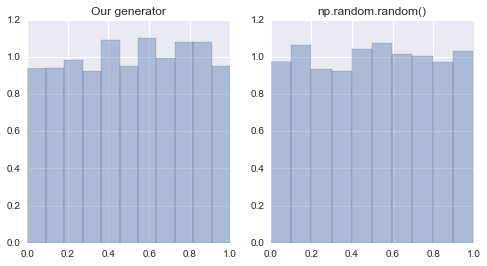

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn

x = 1
u = np.zeros(1000)
a, b, M = 1103515245, 12345, 2**31

for i in xrange(len(u)):
    x_new = (a*x + b) % M
    u[i] = float(x_new) / M
    x = x_new
    
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
# you can also use plt.hist(u),
# here I just want to make it more beatiful.
seaborn.distplot(u, kde=False, norm_hist=True)
plt.title('Our generator')

plt.subplot(1,2,2)
np.random.seed(1)
seaborn.distplot(np.random.random(1000), kde=False, norm_hist=True)
plt.title('np.random.random()')

## Probability density functions

We often say a random variable $X\sim f(x)$, where $f(x)$ is a probability density function. 

### One view

We can think of it a propotion/frequency of how often $X_1, X_2, \ldots X_n$ falls into a bin $(x, x+\Delta x)$ divided by the size of the area $\Delta x$:
$$f(x) = \dfrac{P\left(X \in (x, x+\Delta x)\right)}{\Delta x}.$$

Obviously,
$$\int f(x)\; dx = 1.$$

### Another view

Another way is to think of $f(x)$ a huge population of points $\{x_1, x_2, \ldots, x_m\}$. When we draw a sample $X\sim f(x)$, it is simply a random sample from this population:
$$X \sim \textrm{unif} \{x_1, x_2, \ldots, x_m\}.$$

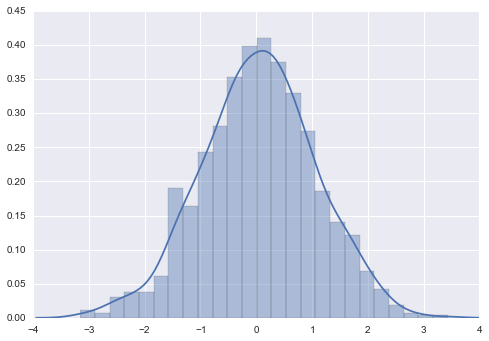

In [3]:
# plots 1000 standard normal samples into bins.
seaborn.distplot(np.random.standard_normal(1000));
plt.xlim([-4,4]);

## Cumulative density function

The cumulative density function is 
$$F(x) = P(X\leq x)= \int_{-\infty}^{x} f(x)\;dx.$$

Conversely, the probability density function is the derivative of the cumulative density function.
$$
f(x) = F'(x) = \dfrac{F(x+\Delta x) - F(x)}{\Delta x} = \dfrac{P\left(X \in (x, x+\Delta x)\right)}{\Delta x}.
$$

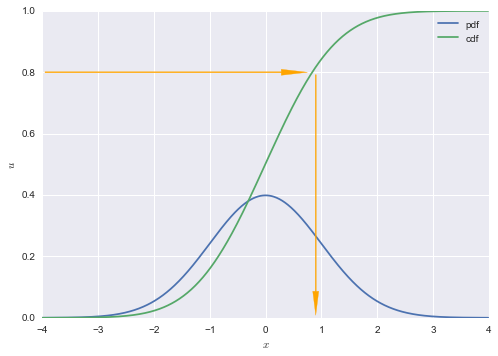

In [4]:
import matplotlib.mlab as mlab

dx = .01
x = np.arange(-4, 4, dx)

# probility density function of N(0, 1)
pdf = mlab.normpdf(x, 0, 1.0)

# cumulative density function
cdf = np.cumsum(pdf*dx)

# plot the curves
plt.plot(x, pdf, label='pdf')
plt.plot(x, cdf, label='cdf')
plt.annotate('', xy=(0.8, 0.8), xytext=(-4, 0.8),
            arrowprops=dict(color='orange', shrink=0.01, width=1, headwidth=6))
plt.annotate('', xy=(0.9, 0), xytext=(0.9, 0.8),
            arrowprops=dict(color='orange', shrink=0.01, width=1, headwidth=6))
plt.ylabel('$u$')
plt.xlabel('$x$')
plt.legend(loc='best');

## Inversion Sampling

When given a percentage $u = F(x)\in [0, 1]$, we can find a percentile $x = F^{-1}(u)$ such that $x\sim f(x)$.

As shown by the orange arrows in the figure above, to draw a sample $X\sim f(x)$ using the random number generator, we can do the following two steps:
* Generate a random number $u \sim \textrm{unif}[0, 1]$,
* Find out the $x \sim F^{-1}(u)$ by the inverse of CDF function.

### Example: exponential distribution.

To sample from the exponential distribution
$$
X \sim f(x) = \left\{
  \begin{array}{lr}
    e^{-x} & : x \geq 0\\
    0 & : x < 0
  \end{array}\right.
$$

We derive the cumulative function $F(x) = 1 - e^{-x}$. Let $F(x) = u$, we have $x = -\log (1-u)$.

Therefore, we can generate sample $u$ and obtain $X = -\log (1-u)$ following the exponential distribution.

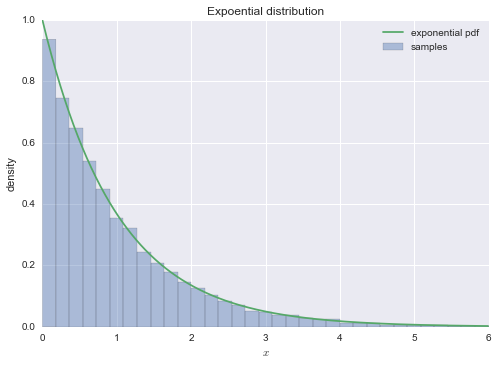

In [24]:
dx = .01
x = np.arange(0, 6, dx)

pdf = np.exp(-x)
seaborn.distplot(-np.log(1 - np.random.random(10000)), kde=False, norm_hist=True, label="samples");
plt.plot(x, pdf, label='exponential pdf')
plt.title('Expoential distribution')
plt.legend()
plt.ylabel('density')
plt.xlim([0, 6])
plt.xlabel('$x$');

### Example: standard normal distribution with polar method

In this example, we want to generate samples $X \sim N(0, 1)$ with density function
$$ f(x) = \dfrac{1}{\sqrt{2\pi}} e^{-\frac{x^2}{2}}$$

People usually perform a polar transformation and generate two independent copies $(X, Y) \sim N(0,1)$ at the same time.

Consider the joint density
$$
f(x, y) = f(x)\cdot f(y) = \dfrac{1}{2\pi} e^{-\frac{x^2+y^2}{2}}.
$$

Let's parameterize $x = r\cos \theta, y = r\sin \theta$ for $\theta \in [0, 2\pi)$, then the density only depends on $r$.

Since the density $f(x,y) = \dfrac{\textrm{# of points in }D_{xy}}{\textrm{aera of } D_{xy}}$ for a region $D_{xy}$, where
the aera is $r \cdot dr \cdot d\theta$. Hence the number of points in region $D_{xy}$ is $f(x,y) r dr d \theta$.

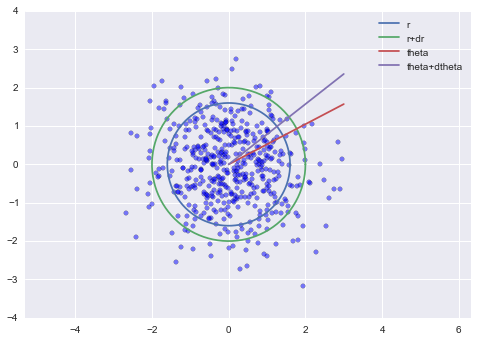

In [112]:
# draw points
true = np.random.standard_normal(1000)
true_x, true_y = true[:500], true[500:]
plt.scatter(true_x, true_y, alpha=0.5)

# draw r and theta
theta = np.linspace(0, 2*np.pi, 100)
r, r2 = 1.6, 2
plt.plot(r*np.cos(theta), r*np.sin(theta), label='r')
plt.plot(r2*np.cos(theta), r2*np.sin(theta), label='r+dr')

x = np.array([0, 3])
t1, t2 = np.pi/6, 1.5*np.pi/6
plt.plot(x, t1*x, label='theta')
plt.plot(x, t2*x, label='theta+dtheta')

plt.legend()
plt.axis('equal');

Suppose $R$ and $\Theta$ are random variables.
We have $\Theta\sim \textrm{uniform}[0, 2\pi)$, i.e. $\Theta = 2\pi \cdot U$.

$$
\begin{align}
P(R \in (r, r+\delta r)) &= f(x,y) r \;drd\theta  \\
F(r) = P(R \leq r) &= \int_{0}^{2\pi}\int_{0}^{r} \dfrac{1}{2\pi}e^{-\frac{r^2}{2}} r \;dr d\theta = 1 - e^{-\frac{r^2}{2}}
\end{align}
$$

Let $F(r) = u$, we have $r = \sqrt{-2\log u}$.

To sum up, we can generate two independent samples with two random numbers:
$$
\begin{align}
\Theta &= 2\pi \cdot U_1\\
R &= \sqrt{-2\log U_2} \\
X &= R\cos\Theta \\
Y &= R\sin\Theta.
\end{align}
$$

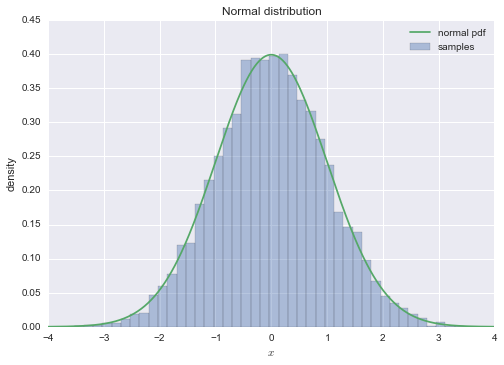

In [62]:
# Generator
theta = 2 * np.pi * np.random.random(2000)
r = np.sqrt(-2 * np.log(np.random.random(2000)))

samples = np.hstack([r*np.cos(theta), r*np.sin(theta)])
    
dx = .01
x = np.arange(-4, 4, dx)

# probility density function of N(0, 1)
pdf = mlab.normpdf(x, 0, 1.0)
seaborn.distplot(samples, kde=False, norm_hist=True, label="samples");
plt.plot(x, pdf, label='normal pdf')
plt.title('Normal distribution')
plt.legend()
plt.ylabel('density')
plt.xlim([-4, 4])
plt.xlabel('$x$');

## Rejection Sampling

Instead of sample from $f(x)$, we sample from another density $M\cdot g(x)$ which envelopes f(x), where $M$ is a large integer and $g(x)$ is a density that is much easier to sample from.

Rejection sampling says we generate uniform samples under $Mg(x)$ but only keep the points under $f(x)$ and return the horizontal coordinates of the points kept. The acceptance rate is $1/M$.

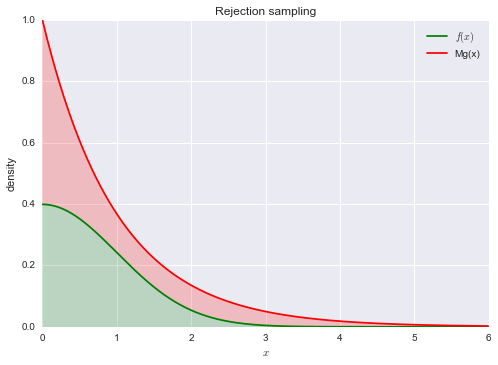

In [225]:
dx = .01
x = np.arange(0, 6, dx)

M = 1

def f(x):
    return (1/np.sqrt(2*np.pi)) * np.exp(-np.power(x, 2) / 2)

def g(x):
    return np.exp(-x)

plt.plot(x, f(x), label='$f(x)$', color='green')
plt.plot(x, M*g(x), label='Mg(x)', color='red')
plt.fill_between(x, f(x), 0, color='green', alpha=0.2, label='accept')
plt.fill_between(x, M*g(x), f(x), color='red', alpha=0.2, label='reject')
plt.title('Rejection sampling')
plt.legend()
plt.ylabel('density')
plt.xlim([0, 6])
plt.xlabel('$x$');

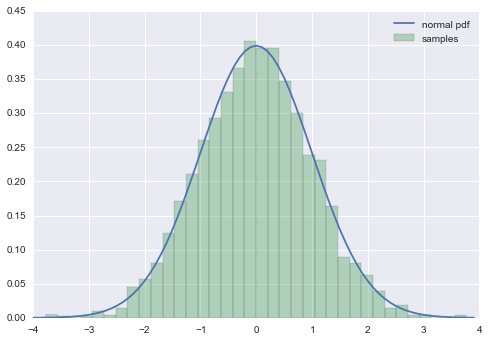

In [257]:
# Rejection sampling,
x = -np.log(1 - np.random.random(4000)) # Sample x from g(x), exp dist.
u = np.random.random(4000)              # generate u from unif(0,1).
keep = u < (f(x) / (M*g(x)))            # accept if f(x) / Mg(x).

# Flip the sign of half accepted examples.
samples = x[keep]
samples[:len(samples)/2] = -samples[:len(samples)/2] 

# Plot histogram of samples and standard normal pdf.
lx = np.arange(-4, 4, 0.1)
plt.plot(lx, mlab.normpdf(lx, 0, 1.0), label='normal pdf')
seaborn.distplot(samples, kde=False, norm_hist=True, label="samples");
plt.legend();